In [1]:
# Loading important libraries

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn import svm

import statsmodels.api as sm

from scipy import stats

In [2]:
# Loading dataset

df = pd.read_csv("lego_sets.csv")

In [3]:
# Get quick overview of dataset

df.describe()

,list_price,num_reviews,piece_count,play_star_rating,prod_id,star_rating,val_star_rating
count,12261.000000,10641.000000,12261.000000,10486.000000,1.226100e+04,10641.000000,10466.000000
mean,65.141998,16.826238,493.405921,4.337641,5.983675e+04,4.514134,4.228960
std,91.980429,36.368984,825.364580,0.652051,1.638115e+05,0.518865,0.660282
min,2.272400,1.000000,1.000000,1.000000,6.300000e+02,1.800000,1.000000
25%,19.990000,2.000000,97.000000,4.000000,2.103400e+04,4.300000,4.000000
50%,36.587800,6.000000,216.000000,4.500000,4.206900e+04,4.700000,4.300000
75%,70.192200,13.000000,544.000000,4.800000,7.092200e+04,5.000000,4.700000
max,1104.870000,367.000000,7541.000000,5.000000,2.000431e+06,5.000000,5.000000


In [4]:
# Removing unnecessary columns

df = df.drop(["prod_desc", "prod_id", "prod_long_desc"], axis=1)

## DATA PREP

Checking data type of all column to see if any column has incorrect data type

In [5]:
# Finding data values of variables

df.dtypes

ages                  object
list_price           float64
num_reviews          float64
piece_count          float64
play_star_rating     float64
review_difficulty     object
set_name              object
star_rating          float64
theme_name            object
val_star_rating      float64
country               object
dtype: object

Checking if any column includes missing values.

Looks like num_reviews, play_star_rating, review_difficulty, star_rating, theme_name and val_star_rating has missing records

In [6]:
df.isnull().any()

ages                 False
list_price           False
num_reviews           True
piece_count          False
play_star_rating      True
review_difficulty     True
set_name             False
star_rating           True
theme_name            True
val_star_rating       True
country              False
dtype: bool

After Looking at "set_name" values, it seems that this column might be useful but because it has too many unique value it will cause mess for regression model when we convert this categorical feature into dummy variable. So lets remove this

Same can be said about "theme_name", but we noticed a pattern where brand name lego sets have ™|® encoded in their value so we can extract this information from theme_name and delete it afterward

In [7]:
df['brandname_flag'] = df['theme_name'].str.contains('™|®')*1

In [8]:
# Dropping set_name and theme_name

df.drop(['set_name', 'theme_name'], axis=1, inplace=True)

In [9]:
df.isnull().sum()

ages                    0
list_price              0
num_reviews          1620
piece_count             0
play_star_rating     1775
review_difficulty    2055
star_rating          1620
val_star_rating      1795
country                 0
brandname_flag          3
dtype: int64

Removing null values

In [10]:
df = df.dropna()

In [11]:
df.isnull().sum()

ages                 0
list_price           0
num_reviews          0
piece_count          0
play_star_rating     0
review_difficulty    0
star_rating          0
val_star_rating      0
country              0
brandname_flag       0
dtype: int64

In [12]:
df.shape

(10162, 10)

In [13]:
df.head()

,ages,list_price,num_reviews,piece_count,play_star_rating,review_difficulty,star_rating,val_star_rating,country,brandname_flag
0,6-12,29.99,2.0,277.0,4.0,Average,4.5,4.0,US,1
1,6-12,19.99,2.0,168.0,4.0,Easy,5.0,4.0,US,1
2,6-12,12.99,11.0,74.0,4.3,Easy,4.3,4.1,US,1
3,12+,99.99,23.0,1032.0,3.6,Average,4.6,4.3,US,0
4,12+,79.99,14.0,744.0,3.2,Challenging,4.6,4.1,US,0


Dummy encoding categorical values

In [14]:
categorical_cols = ['ages', 'review_difficulty', 'country']

In [15]:
df = pd.get_dummies(df, columns= categorical_cols, drop_first=True)

In [16]:
df

,list_price,num_reviews,piece_count,play_star_rating,star_rating,val_star_rating,brandname_flag,ages_10-14,ages_10-16,ages_10-21,...,country_GB,country_IE,country_IT,country_LU,country_NL,country_NO,country_NZ,country_PL,country_PT,country_US
0,29.9900,2.0,277.0,4.0,4.5,4.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,19.9900,2.0,168.0,4.0,5.0,4.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,12.9900,11.0,74.0,4.3,4.3,4.1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,99.9900,23.0,1032.0,3.6,4.6,4.3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,79.9900,14.0,744.0,3.2,4.6,4.1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12256,36.5878,6.0,341.0,4.4,4.3,4.2,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12257,24.3878,8.0,217.0,4.1,3.6,4.1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12258,24.3878,18.0,233.0,4.6,4.6,4.5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12259,12.1878,1.0,48.0,5.0,5.0,5.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Splitting data into Test and Train set

In [17]:
X = df.drop(['list_price'], axis=1)
y = df.list_price

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
X_train

,num_reviews,piece_count,play_star_rating,star_rating,val_star_rating,brandname_flag,ages_10-14,ages_10-16,ages_10-21,ages_11-16,...,country_GB,country_IE,country_IT,country_LU,country_NL,country_NO,country_NZ,country_PL,country_PT,country_US
9581,7.0,221.0,4.3,4.1,4.3,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11943,4.0,871.0,5.0,4.8,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5399,3.0,506.0,5.0,5.0,5.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
963,1.0,135.0,1.0,4.0,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9002,4.0,192.0,5.0,5.0,5.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11131,28.0,370.0,4.6,4.5,4.2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5841,2.0,67.0,5.0,5.0,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3903,21.0,494.0,4.6,4.5,4.8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11860,9.0,643.0,4.4,4.8,3.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
X_test

,num_reviews,piece_count,play_star_rating,star_rating,val_star_rating,brandname_flag,ages_10-14,ages_10-16,ages_10-21,ages_11-16,...,country_GB,country_IE,country_IT,country_LU,country_NL,country_NO,country_NZ,country_PL,country_PT,country_US
10602,15.0,1403.0,4.5,4.8,4.8,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3349,11.0,444.0,3.6,4.8,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188,6.0,271.0,4.5,4.8,4.5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9068,115.0,2382.0,4.5,4.7,4.2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4085,1.0,106.0,4.0,5.0,4.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5562,1.0,57.0,5.0,5.0,5.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4603,5.0,143.0,4.6,5.0,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1198,13.0,8.0,4.3,4.8,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10004,19.0,3444.0,4.9,5.0,4.9,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# Linear Regression Model

In [21]:
lr = LinearRegression()

In [22]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
print("Intercept at : {}".format(lr.intercept_))
print("Co-efficient at : {}".format(lr.coef_))

Intercept at : 81.56142851308874
Co-efficient at : [ 1.40791966e-01  1.07935365e-01  1.15793616e+01 -3.94506564e+00
 -2.01724859e+01  1.25375082e+01 -2.41473788e+01 -2.44322297e+01
  9.51438881e+01 -5.41163879e+01 -3.26852057e+01 -1.00084624e+02
 -2.93888844e+01 -1.11871999e+02 -1.64711008e+01 -1.80835173e+01
  1.12219196e+01 -2.52739592e+01 -7.89301061e+00 -2.29500855e+01
 -1.53232355e+01 -1.84407795e+01  6.68732259e+00  7.88849129e+01
 -2.13728812e+01 -3.19036023e+01 -1.69588811e+01 -1.96064318e+01
 -2.49447969e+01 -2.55638181e+01 -2.24358972e+01 -2.83429737e+01
 -4.22218603e+01 -3.86706973e+01 -3.91409863e+01 -1.12603727e+01
  4.57377618e+00 -9.81524073e+00  1.94248805e+01 -1.63043958e+01
 -5.90378755e-01  6.75510927e+00 -9.17391684e+00 -1.30254086e-01
  8.04158837e+00  4.31986641e+00 -8.61551179e+00  4.58999537e+00
  1.36013387e+01  5.09623193e+00  1.44609245e+00  1.31162639e+00
  2.37697191e+00  5.79835819e+00  7.36788402e+00  1.25656910e+01
  6.27336407e+00  4.97587206e+00  4.528

Creating Predictor by predicting our Test set and compare those with ACTUAL value of Test set

In [24]:
y_pred = lr.predict(X_test)

In [25]:
# Calculating r-score
r_score = r2_score(y_test,y_pred)
print("R^2 score of SVR model: {}".format(r_score))

R^2 score of SVR model: 0.8401374931169628


In [26]:
# Mean Absolute Error, Mean Squared Error and Root Mean Squared Error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error for Linear Regression: {}".format(mae))
print("Mean Squared Error for Linear Regression: {}".format(mse))
print("Root Mean Squared Error for Linear Regression: {}".format(rmse))

Mean Absolute Error for Linear Regression: 20.308480110250656
Mean Squared Error for Linear Regression: 1765.9679901486836
Root Mean Squared Error for Linear Regression: 42.0234219233594


Not that great of a score, but lets visualize it to get a better idea

In [27]:
df_output = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

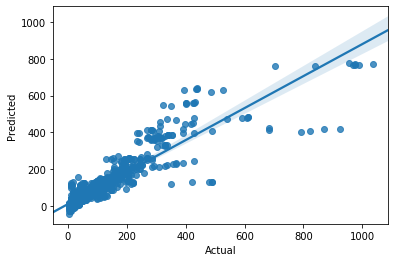

In [28]:
sns.regplot(x="Actual", y="Predicted", data=df_output)

In [29]:
df_output

,Actual,Predicted
10602,134.1878,152.213910
3349,50.8980,30.191182
188,29.9900,25.741247
9068,207.3878,202.195556
4085,95.9520,61.031319
...,...,...
5562,15.4800,4.140786
4603,12.1878,24.882077
1198,4.5524,2.202193
10004,389.8700,394.422325


In [30]:
lr_OLS = sm.OLS(endog=y, exog=X.astype(float)).fit()
lr_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             list_price   R-squared (uncentered):                   0.884
Model:                            OLS   Adj. R-squared (uncentered):              0.883
Method:                 Least Squares   F-statistic:                              1279.
Date:                Sat, 11 Jan 2020   Prob (F-statistic):                        0.00
Time:                        20:45:55   Log-Likelihood:                         -52319.
No. Observations:               10162   AIC:                                  1.048e+05
Df Residuals:                   10102   BIC:                                  1.052e+05
Df Model:                          60                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
num_reviews                            0.1705      0.017      9.899      0.000       0.137       0.204
piece_count                            0.1066      0.001    117.721      0.000       0.105       0.108
play_star_rating                      11.6418      1.016     11.455      0.000       9.650      13.634
star_rating                            8.2511      1.212      6.806      0.000       5.875      10.628
val_star_rating                      -19.8839      0.947    -20.994      0.000     -21.740     -18.027
brandname_flag                        14.7772      1.187     12.453      0.000      12.451      17.103
ages_10-14                           -16.8082      9.493     -1.771      0.077     -35.417       1.801
ages_10-16                           -15.7477      3.937     -4.000      0.000     -23.466      -8.030
ages_10-21                            96.2941      5.948     16.188      0.000      84.634     107.954
ages_11-16                           -38.3338      5.698     -6.727      0.000     -49.504     -27.164
ages_12+                             -21.6953      3.003     -7.225      0.000     -27.582     -15.809
ages_12-16                           -88.5165      7.032    -12.587      0.000    -102.302     -74.731
ages_14+                             -22.8627      4.412     -5.182      0.000     -31.510     -14.215
ages_16+                            -107.1186      4.383    -24.439      0.000    -115.710     -98.527
ages_1½-3                              3.5950      6.466      0.556      0.578      -9.080      16.270
ages_1½-5                            -14.2713      5.563     -2.566      0.010     -25.175      -3.367
ages_2-5                              14.1346      3.007      4.700      0.000       8.239      20.030
ages_4+                              -28.1686      9.783     -2.879      0.004     -47.344      -8.993
ages_4-7                               0.8881      2.545      0.349      0.727      -4.100       5.876
ages_4-99                            -13.5548      3.075     -4.408      0.000     -19.583      -7.527
ages_5+                              -11.5312      5.427     -2.125      0.034     -22.170      -0.892
ages_5-12                             -7.8753      2.292     -3.437      0.001     -12.367      -3.383
ages_5-8                              10.3996      9.498      1.095      0.274      -8.218      29.017
ages_6+                               90.1961      4.145     21.762      0.000      82.072      98.321
ages_6-12                            -10.5240      2.091     -5.034      0.000     -14.622      -6.426
ages_6-14                            -28.6053      4.089     -6.995      0.000     -36.621     -20.5

# SUPPORT VECTOR REGRESSION

In [31]:
X = df.drop(['list_price'], axis=1).values
y = df.list_price.values

In [32]:
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y.reshape(-1,1))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
svr = svm.SVR()
svr.fit(X_train, y_train)

C:\Users\Sidd\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Sidd\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
y_pred = svr.predict(X_test)

y_pred = sc_y.inverse_transform(y_pred)
y_test = sc_y.inverse_transform(y_test)

In [36]:
df_output = pd.DataFrame({'Actual':y_test.ravel(), 'Predicted':y_pred})
df_output

,Actual,Predicted
0,134.1878,145.145361
1,50.8980,53.657890
2,29.9900,29.915915
3,207.3878,238.325676
4,95.9520,57.980526
...,...,...
2028,15.4800,9.309076
2029,12.1878,13.183889
2030,4.5524,14.470392
2031,389.8700,373.862585


In [37]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error for Linear Regression: {}".format(mae))
print("Mean Squared Error for Linear Regression: {}".format(mse))
print("Root Mean Squared Error for Linear Regression: {}".format(rmse))

Mean Absolute Error for Linear Regression: 13.58660417914955
Mean Squared Error for Linear Regression: 1467.3146478750568
Root Mean Squared Error for Linear Regression: 38.30554330478889


In [38]:
r_score = r2_score(y_test,y_pred)
print("R^2 score of SVR model: {}".format(r_score))

R^2 score of SVR model: 0.8671727917470586


# RANDOM FOREST REGRESSION

In [186]:
X = df.drop(['list_price'], axis=1)
y = df.list_price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [187]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [188]:
y_pred = rf.predict(X_test)

In [189]:
df_output = pd.DataFrame({'Actual':y_test.ravel(), 'Predicted':y_pred})
df_output

,Actual,Predicted
0,134.1878,130.635514
1,50.8980,50.323348
2,29.9900,39.705172
3,207.3878,188.228801
4,95.9520,97.588198
...,...,...
2028,15.4800,15.643237
2029,12.1878,12.187800
2030,4.5524,4.591194
2031,389.8700,371.361951


In [190]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error for Linear Regression: {}".format(mae))
print("Mean Squared Error for Linear Regression: {}".format(mse))
print("Root Mean Squared Error for Linear Regression: {}".format(rmse))

Mean Absolute Error for Linear Regression: 4.320892119478689
Mean Squared Error for Linear Regression: 134.05214287800646
Root Mean Squared Error for Linear Regression: 11.578088913029061


In [191]:
r_score = r2_score(y_test,y_pred)
print("R^2 score of SVR model: {}".format(r_score))

R^2 score of SVR model: 0.9878650622587349


In [192]:
importances = list(rf.feature_importances_)
cols = X.columns.values

In [193]:
importance_cols = pd.DataFrame({'Column':cols, 'Importance':importances})

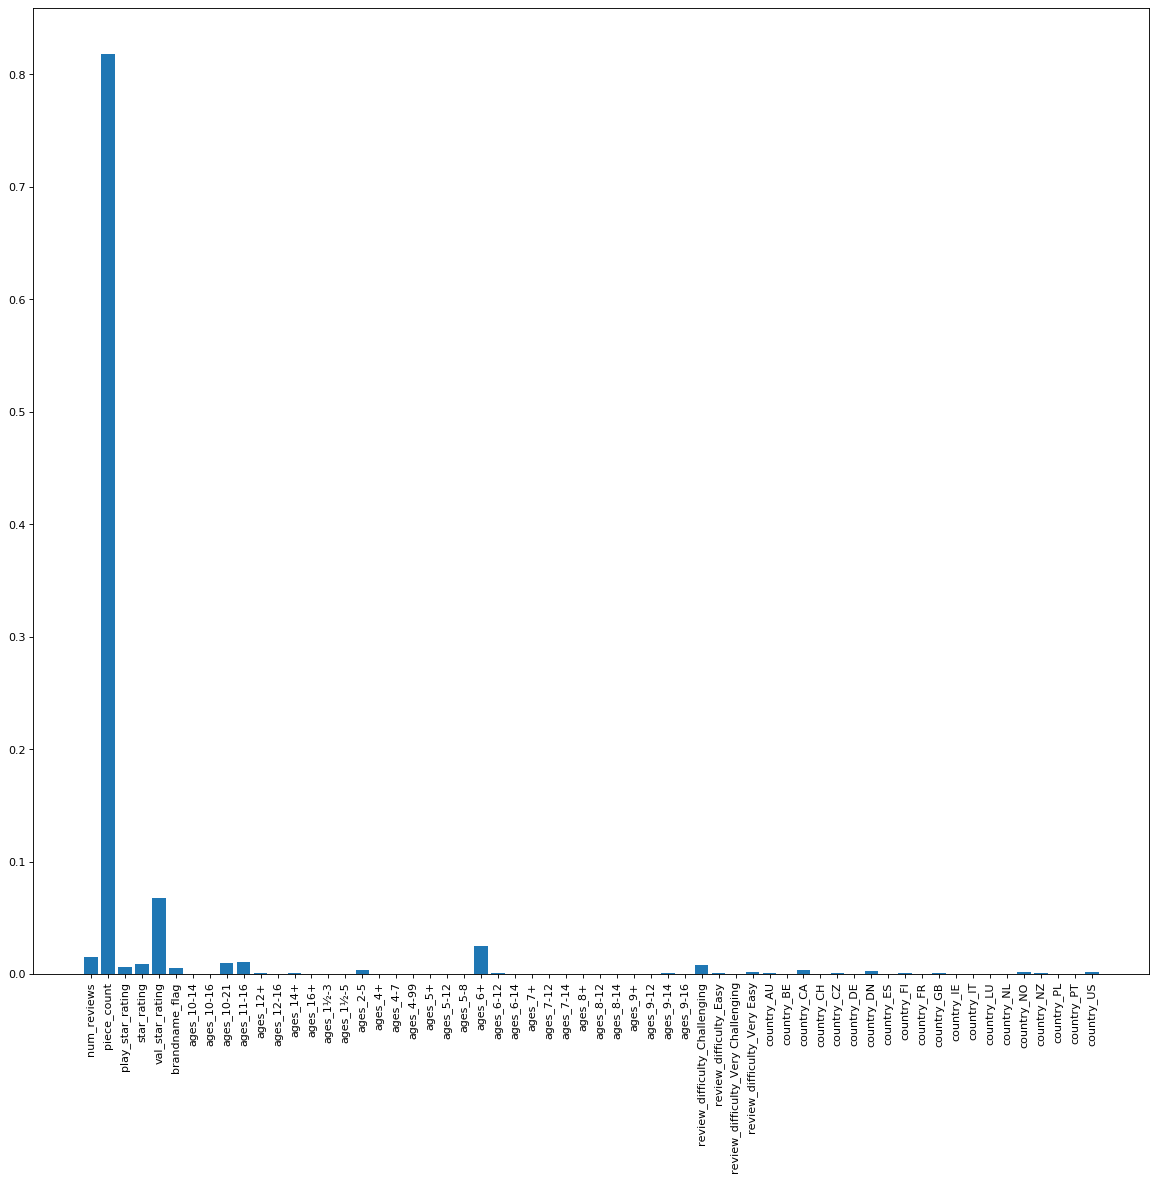

In [194]:
plt.figure(figsize=(18, 16), dpi= 80)
plt.bar(importance_cols.Column, importance_cols.Importance, orientation = 'vertical')
plt.xticks(rotation=90)
plt.show()

We can clearly see that Piece Count is driving price of Lego set high.

In [195]:
y_predict = rf.predict(X)

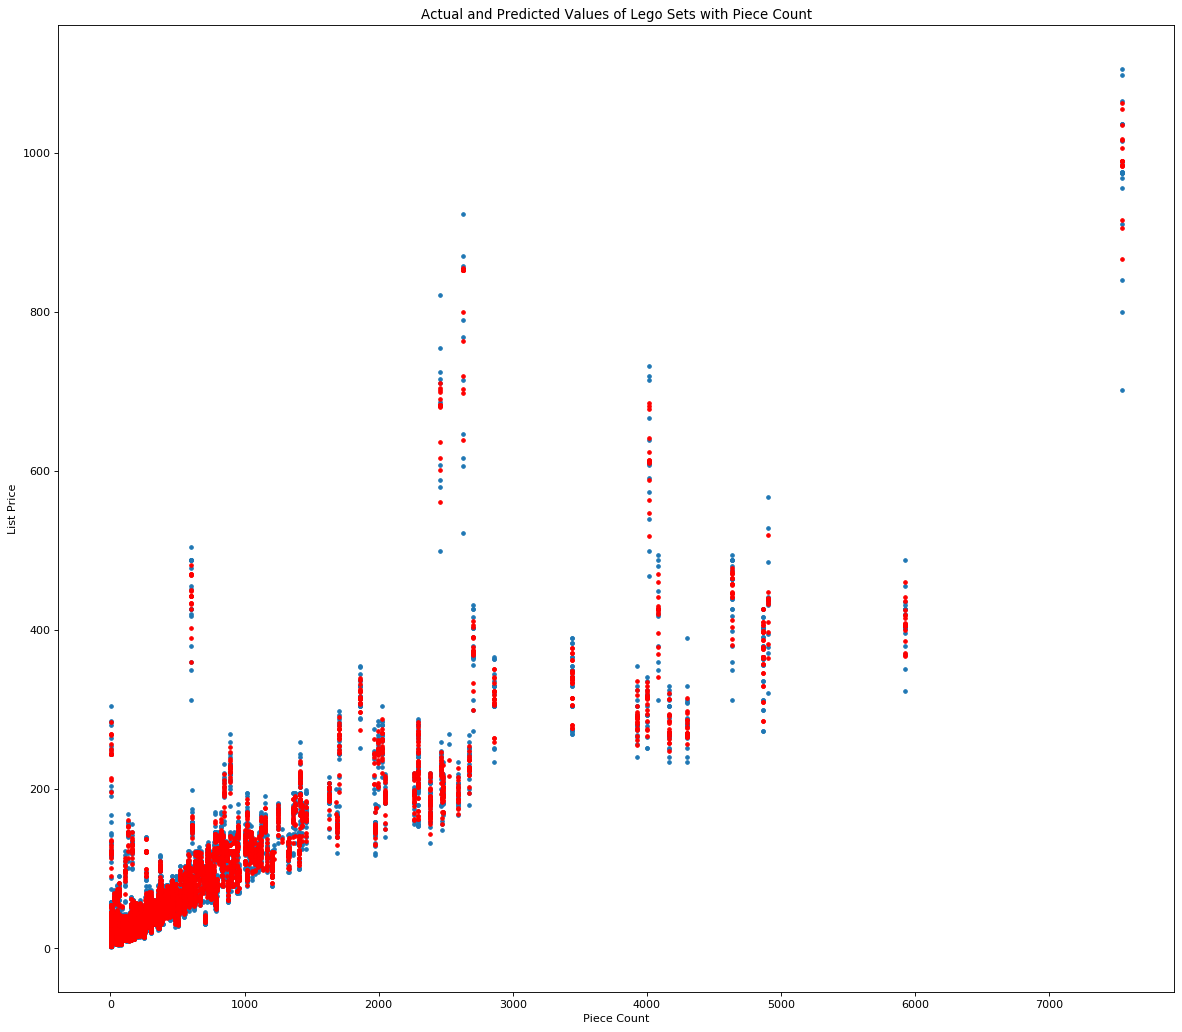

In [196]:
plt.figure(figsize=(18, 16), dpi= 80)
plt.scatter(X['piece_count'], y, s=10, label = "Actual")
plt.scatter(X['piece_count'], y_predict, c="red", s=10, label = "Actual")
plt.title('Actual and Predicted Values of Lego Sets with Piece Count')
plt.xlabel('Piece Count')
plt.ylabel('List Price')
plt.show()